<a href="https://colab.research.google.com/github/fmahboub/Replicating-Sloan-1996-/blob/master/Replicating_Sloan_1996.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install wrds

     |████████████████████████████████| 2.9MB 3.9MB/s 


In [0]:
#%% Tutorial 2: Coding Exercise 1 -- Detect earnings mangement
# Reference: Sloan (1996)

import pandas as pd
import wrds
import matplotlib.pyplot as plt
import statsmodels.api as sm
conn = wrds.Connection()

import numpy as np
from scipy.stats.mstats import winsorize
from scipy import stats

Enter your WRDS username [root]:faran2
Enter your password:··········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [0]:
# 1. Sample selection
funda = conn.raw_sql("""
                      select gvkey, fyear, ni, csho, sich, AT, ACT, CHE, LCT, DLC, TXP, DP, OIADP
	                  from compa.funda where
	                   (consol='C' and indfmt='INDL' and datafmt='STD' and popsrc='D' and exchg='11' or exchg ='12') and
                       fyear<1992 and
                       fyear>1960
                      """) 
company = conn.raw_sql("""
                      select gvkey, sic
	                  from compa.company
                     """) 

funda1=pd.merge(funda,company,on=['gvkey'])
funda1['sic1']=np.where(funda1['sich']>0,funda1['sich'],funda1['sic'])
funda1=funda1.drop(['sich','sic'],axis=1)
funda1['sic1']=funda1['sic1'].astype(int)

# industry restriction
indexNames =funda1[ (funda1['sic1'] >= 4400) & (funda1['sic1'] <= 5000) ].index
funda1.drop(indexNames , inplace=True)
indexNames =funda1[ (funda1['sic1'] >= 6000) & (funda1['sic1'] <= 6500) ].index
funda1.drop(indexNames , inplace=True)

funda1

,gvkey,fyear,ni,csho,at,act,che,lct,dlc,txp,dp,oiadp,sic1
0,001000,1961.0,NaN,0.152,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3089
1,001000,1962.0,NaN,0.181,NaN,NaN,NaN,NaN,NaN,NaN,0.040,NaN,3089
2,001000,1963.0,0.003,0.186,NaN,0.408,NaN,0.322,NaN,0.000,0.046,0.000,3089
3,001000,1964.0,0.052,0.196,1.416,0.718,0.269,0.267,0.088,0.007,0.053,0.074,3089
4,001000,1965.0,-0.197,0.206,2.310,0.725,0.031,0.623,0.300,0.000,0.082,-0.242,3089
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74337,184740,1982.0,-46.217,3.632,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876,1311
74338,184740,1983.0,-27.545,3.632,114.368,15.688,4.704,27.519,12.501,0.000,15.275,12.728,1311
74339,184740,1974.0,0.075,1.408,3.402,0.353,0.039,0.337,0.213,0.000,0.157,0.260,1311
74340,184740,1984.0,-17.090,6.284,112.535,7.812,0.415,21.160,11.671,0.000,11.110,9.219,1311


In [0]:
# generate lag variables
funda1_lag1= funda1[['gvkey','fyear','at','act','che','lct','dlc','txp','dp','oiadp']].copy() 
funda1_lag1['fyear']=funda1_lag1['fyear']+1
funda1_lag1=funda1_lag1.rename(columns={'at':'at_lag1','act':'act_lag1','che':'che_lag1','lct':'lct_lag1',
                                        'dlc':'dlc_lag1','txp':'txp_lag1','dp':'dp_lag1','oiadp':'oiadp_lag1'})

funda2=pd.merge(funda1,funda1_lag1, how='left', on=['gvkey','fyear'])

funda2=funda2.dropna()
funda2

,gvkey,fyear,ni,csho,at,act,che,lct,dlc,txp,dp,oiadp,sic1,at_lag1,act_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,dp_lag1,oiadp_lag1
4,001000,1965.0,-0.197,0.206,2.310,0.725,0.031,0.623,0.300,0.000,0.082,-0.242,3089,1.416,0.718,0.269,0.267,0.088,0.007,0.053,0.074
5,001000,1966.0,0.164,0.219,2.430,1.015,0.063,0.446,0.124,0.000,0.175,0.350,3089,2.310,0.725,0.031,0.623,0.300,0.000,0.082,-0.242
6,001000,1967.0,-0.090,0.219,2.456,1.004,0.029,0.376,0.086,0.000,0.198,0.003,3089,2.430,1.015,0.063,0.446,0.124,0.000,0.175,0.350
7,001000,1968.0,0.463,0.372,5.922,1.865,0.352,1.248,0.128,0.190,0.270,0.753,3089,2.456,1.004,0.029,0.376,0.086,0.000,0.198,0.003
8,001000,1969.0,1.766,2.582,28.712,17.314,1.277,13.980,7.311,1.426,1.033,3.931,3089,5.922,1.865,0.352,1.248,0.128,0.190,0.270,0.753
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69170,184740,1978.0,1.004,2.065,23.810,2.974,0.000,2.860,2.321,0.000,1.157,1.953,1311,11.142,2.024,0.287,1.356,0.177,0.000,0.435,0.797
69171,184740,1982.0,-46.217,3.632,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876,1311,177.177,14.887,1.386,34.463,4.780,0.000,7.972,6.787
69172,184740,1983.0,-27.545,3.632,114.368,15.688,4.704,27.519,12.501,0.000,15.275,12.728,1311,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876
69174,184740,1984.0,-17.090,6.284,112.535,7.812,0.415,21.160,11.671,0.000,11.110,9.219,1311,114.368,15.688,4.704,27.519,12.501,0.000,15.275,12.728


In [0]:
# 2. Variable construction
funda2['AvgAT'] = (funda2['at']+funda2['at_lag1'])/2
funda2['chg_TP'] = funda2['txp']-funda2['txp_lag1']
funda2['chg_STD'] = funda2['dlc']-funda2['dlc_lag1']
funda2['chg_CL'] = funda2['lct']-funda2['lct_lag1']
funda2['chg_Cash'] = funda2['che']-funda2['che_lag1']
funda2['chg_CA'] = funda2['act']-funda2['act_lag1']
funda2['Accruals'] = funda2['chg_CA']-funda2['chg_Cash']-(funda2['chg_CL']-funda2['chg_STD']-funda2['chg_TP']) - funda2['dp']
funda2['AccrualComp'] = funda2['Accruals']/funda2['AvgAT']
funda2['EarningsComp'] = funda2['oiadp']/funda2['AvgAT']
funda2['CF_Comp'] = funda2['EarningsComp'] - funda2['AccrualComp']
funda3 = funda2
funda5 = funda2
funda2

,gvkey,fyear,ni,csho,at,act,che,lct,dlc,txp,dp,oiadp,sic1,at_lag1,act_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,dp_lag1,oiadp_lag1,AvgAT,chg_TP,chg_STD,chg_CL,chg_Cash,chg_CA,Accruals,AccrualComp,EarningsComp,CF_Comp,AccrualDecile,TwoDigSIC
4,001000,1965.0,-0.197,0.206,2.310,0.725,0.031,0.623,0.300,0.000,0.082,-0.242,3089,1.416,0.718,0.269,0.267,0.088,0.007,0.053,0.074,1.8630,-0.007,0.212,0.356,-0.238,0.007,0.012,0.006441,-0.129898,-0.136339,7,30
5,001000,1966.0,0.164,0.219,2.430,1.015,0.063,0.446,0.124,0.000,0.175,0.350,3089,2.310,0.725,0.031,0.623,0.300,0.000,0.082,-0.242,2.3700,0.000,-0.176,-0.177,0.032,0.290,0.084,0.035443,0.147679,0.112236,8,30
6,001000,1967.0,-0.090,0.219,2.456,1.004,0.029,0.376,0.086,0.000,0.198,0.003,3089,2.430,1.015,0.063,0.446,0.124,0.000,0.175,0.350,2.4430,0.000,-0.038,-0.070,-0.034,-0.011,-0.143,-0.058535,0.001228,0.059763,3,30
7,001000,1968.0,0.463,0.372,5.922,1.865,0.352,1.248,0.128,0.190,0.270,0.753,3089,2.456,1.004,0.029,0.376,0.086,0.000,0.198,0.003,4.1890,0.190,0.042,0.872,0.323,0.861,-0.372,-0.088804,0.179757,0.268561,2,30
8,001000,1969.0,1.766,2.582,28.712,17.314,1.277,13.980,7.311,1.426,1.033,3.931,3089,5.922,1.865,0.352,1.248,0.128,0.190,0.270,0.753,17.3170,1.236,7.183,12.732,0.925,15.449,9.178,0.529999,0.227002,-0.302997,Highest,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69170,184740,1978.0,1.004,2.065,23.810,2.974,0.000,2.860,2.321,0.000,1.157,1.953,1311,11.142,2.024,0.287,1.356,0.177,0.000,0.435,0.797,17.4760,0.000,2.144,1.504,-0.287,0.950,0.720,0.041199,0.111753,0.070554,9,13
69171,184740,1982.0,-46.217,3.632,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876,1311,177.177,14.887,1.386,34.463,4.780,0.000,7.972,6.787,165.0850,0.000,13.901,2.981,1.263,0.210,-7.257,-0.043959,0.077996,0.121955,4,13
69172,184740,1983.0,-27.545,3.632,114.368,15.688,4.704,27.519,12.501,0.000,15.275,12.728,1311,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876,133.6805,0.000,-6.180,-9.925,2.055,0.591,-12.994,-0.097202,0.095212,0.192414,2,13
69174,184740,1984.0,-17.090,6.284,112.535,7.812,0.415,21.160,11.671,0.000,11.110,9.219,1311,114.368,15.688,4.704,27.519,12.501,0.000,15.275,12.728,113.4515,0.000,-0.830,-6.359,-4.289,-7.876,-9.168,-0.080810,0.081259,0.162069,2,13


In [0]:
for year in funda2.groupby(['fyear']):
  funda2['AccrualDecile'] = pd.qcut(funda2['AccrualComp'],10,labels=['Lowest',2,3,4,5,6,7,8,9,'Highest'])
funda2

,gvkey,fyear,ni,csho,at,act,che,lct,dlc,txp,dp,oiadp,sic1,at_lag1,act_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,dp_lag1,oiadp_lag1,AvgAT,chg_TP,chg_STD,chg_CL,chg_Cash,chg_CA,Accruals,AccrualComp,EarningsComp,CF_Comp,AccrualDecile,TwoDigSIC
4,001000,1965.0,-0.197,0.206,2.310,0.725,0.031,0.623,0.300,0.000,0.082,-0.242,3089,1.416,0.718,0.269,0.267,0.088,0.007,0.053,0.074,1.8630,-0.007,0.212,0.356,-0.238,0.007,0.012,0.006441,-0.129898,-0.136339,7,30
5,001000,1966.0,0.164,0.219,2.430,1.015,0.063,0.446,0.124,0.000,0.175,0.350,3089,2.310,0.725,0.031,0.623,0.300,0.000,0.082,-0.242,2.3700,0.000,-0.176,-0.177,0.032,0.290,0.084,0.035443,0.147679,0.112236,8,30
6,001000,1967.0,-0.090,0.219,2.456,1.004,0.029,0.376,0.086,0.000,0.198,0.003,3089,2.430,1.015,0.063,0.446,0.124,0.000,0.175,0.350,2.4430,0.000,-0.038,-0.070,-0.034,-0.011,-0.143,-0.058535,0.001228,0.059763,3,30
7,001000,1968.0,0.463,0.372,5.922,1.865,0.352,1.248,0.128,0.190,0.270,0.753,3089,2.456,1.004,0.029,0.376,0.086,0.000,0.198,0.003,4.1890,0.190,0.042,0.872,0.323,0.861,-0.372,-0.088804,0.179757,0.268561,2,30
8,001000,1969.0,1.766,2.582,28.712,17.314,1.277,13.980,7.311,1.426,1.033,3.931,3089,5.922,1.865,0.352,1.248,0.128,0.190,0.270,0.753,17.3170,1.236,7.183,12.732,0.925,15.449,9.178,0.529999,0.227002,-0.302997,Highest,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69170,184740,1978.0,1.004,2.065,23.810,2.974,0.000,2.860,2.321,0.000,1.157,1.953,1311,11.142,2.024,0.287,1.356,0.177,0.000,0.435,0.797,17.4760,0.000,2.144,1.504,-0.287,0.950,0.720,0.041199,0.111753,0.070554,9,13
69171,184740,1982.0,-46.217,3.632,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876,1311,177.177,14.887,1.386,34.463,4.780,0.000,7.972,6.787,165.0850,0.000,13.901,2.981,1.263,0.210,-7.257,-0.043959,0.077996,0.121955,4,13
69172,184740,1983.0,-27.545,3.632,114.368,15.688,4.704,27.519,12.501,0.000,15.275,12.728,1311,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876,133.6805,0.000,-6.180,-9.925,2.055,0.591,-12.994,-0.097202,0.095212,0.192414,2,13
69174,184740,1984.0,-17.090,6.284,112.535,7.812,0.415,21.160,11.671,0.000,11.110,9.219,1311,114.368,15.688,4.704,27.519,12.501,0.000,15.275,12.728,113.4515,0.000,-0.830,-6.359,-4.289,-7.876,-9.168,-0.080810,0.081259,0.162069,2,13


In [0]:
AccrualsMean = funda2.groupby(['AccrualDecile'])['AccrualComp'].mean()
AccrualsMedian = funda2.groupby(['AccrualDecile'])['AccrualComp'].median()
CFMean = funda2.groupby(['AccrualDecile'])['CF_Comp'].mean()
CFMedian = funda2.groupby(['AccrualDecile'])['CF_Comp'].median()
EarningsMean = funda2.groupby(['AccrualDecile'])['EarningsComp'].mean()
EarningsMedian = funda2.groupby(['AccrualDecile'])['EarningsComp'].median()
Tab1A = AccrualsMean.to_frame().transpose().rename(index={'AccrualComp': 'Accruals Mean'})
Tab1A = Tab1A.append(AccrualsMedian.to_frame().transpose().rename(index={'AccrualComp': 'Accruals Median'}))
Tab1A = Tab1A.append(CFMean.to_frame().transpose().rename(index={'CF_Comp': 'Cash Flows Mean'}))
Tab1A = Tab1A.append(CFMedian.to_frame().transpose().rename(index={'CF_Comp': 'Cash Flows Median'}))
Tab1A = Tab1A.append(EarningsMean.to_frame().transpose().rename(index={'EarningsComp': 'Earnings Mean'}))
Tab1A = Tab1A.append(EarningsMedian.to_frame().transpose().rename(index={'EarningsComp': 'Earnings Median'}))
Tab1A = Tab1A.round(2)
Tab1A

AccrualDecile,Lowest,2,3,4,5,6,7,8,9,Highest
Accruals Mean,-0.19,-0.09,-0.07,-0.05,-0.03,-0.02,0.00,0.03,0.06,0.18
Accruals Median,-0.15,-0.09,-0.07,-0.05,-0.03,-0.02,0.00,0.03,0.06,0.14
Cash Flows Mean,0.24,0.19,0.17,0.16,0.15,0.14,0.13,0.11,0.09,-0.01
Cash Flows Median,0.22,0.18,0.16,0.16,0.14,0.13,0.12,0.11,0.08,-0.00
Earnings Mean,0.05,0.09,0.11,0.11,0.12,0.12,0.13,0.14,0.15,0.17
Earnings Median,0.06,0.09,0.10,0.11,0.11,0.11,0.12,0.13,0.14,0.15


In [0]:
funda3['TwoDigSIC'] = funda3['sic1'].astype(str).str[:2].astype(int)
# generate lag variables
funda3_lag1= funda3[['gvkey','fyear','EarningsComp', 'AccrualComp','CF_Comp']].copy() 
funda3_lag1['fyear']=funda3_lag1['fyear']+1
funda3_lag1=funda3_lag1.rename(columns={'EarningsComp':'EarningsComp_lag1','AccrualComp':'AccrualsComp_lag1','CF_Comp':'CF_Comp_lag1'})
funda3=pd.merge(funda3,funda3_lag1, how='left', on=['gvkey','fyear'])
funda4=funda3.dropna()
funda4

,gvkey,fyear,ni,csho,at,act,che,lct,dlc,txp,dp,oiadp,sic1,at_lag1,act_lag1,che_lag1,lct_lag1,dlc_lag1,txp_lag1,dp_lag1,oiadp_lag1,AvgAT,chg_TP,chg_STD,chg_CL,chg_Cash,chg_CA,Accruals,AccrualComp,EarningsComp,CF_Comp,AccrualDecile,TwoDigSIC,EarningsComp_lag1,AccrualsComp_lag1,CF_Comp_lag1
1,001000,1966.0,0.164,0.219,2.430,1.015,0.063,0.446,0.124,0.000,0.175,0.350,3089,2.310,0.725,0.031,0.623,0.300,0.000,0.082,-0.242,2.3700,0.000,-0.176,-0.177,0.032,0.290,0.084,0.035443,0.147679,0.112236,8,30,-0.129898,0.006441,-0.136339
2,001000,1967.0,-0.090,0.219,2.456,1.004,0.029,0.376,0.086,0.000,0.198,0.003,3089,2.430,1.015,0.063,0.446,0.124,0.000,0.175,0.350,2.4430,0.000,-0.038,-0.070,-0.034,-0.011,-0.143,-0.058535,0.001228,0.059763,3,30,0.147679,0.035443,0.112236
3,001000,1968.0,0.463,0.372,5.922,1.865,0.352,1.248,0.128,0.190,0.270,0.753,3089,2.456,1.004,0.029,0.376,0.086,0.000,0.198,0.003,4.1890,0.190,0.042,0.872,0.323,0.861,-0.372,-0.088804,0.179757,0.268561,2,30,0.001228,-0.058535,0.059763
4,001000,1969.0,1.766,2.582,28.712,17.314,1.277,13.980,7.311,1.426,1.033,3.931,3089,5.922,1.865,0.352,1.248,0.128,0.190,0.270,0.753,17.3170,1.236,7.183,12.732,0.925,15.449,9.178,0.529999,0.227002,-0.302997,Highest,30,0.179757,-0.088804,0.268561
5,001000,1970.0,0.558,2.446,33.450,21.351,1.660,19.595,12.378,0.340,1.352,4.034,3089,28.712,17.314,1.277,13.980,7.311,1.426,1.033,3.931,31.0810,-1.086,5.067,5.615,0.383,4.037,0.668,0.021492,0.129790,0.108298,8,30,0.227002,0.529999,-0.302997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37970,184740,1977.0,0.318,1.999,11.142,2.024,0.287,1.356,0.177,0.000,0.435,0.797,1311,5.145,0.653,0.095,0.562,0.160,0.000,0.215,0.159,8.1435,0.000,0.017,0.794,0.192,1.371,-0.033,-0.004052,0.097869,0.101922,7,13,0.033396,-0.039908,0.073304
37971,184740,1978.0,1.004,2.065,23.810,2.974,0.000,2.860,2.321,0.000,1.157,1.953,1311,11.142,2.024,0.287,1.356,0.177,0.000,0.435,0.797,17.4760,0.000,2.144,1.504,-0.287,0.950,0.720,0.041199,0.111753,0.070554,9,13,0.097869,-0.004052,0.101922
37972,184740,1982.0,-46.217,3.632,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876,1311,177.177,14.887,1.386,34.463,4.780,0.000,7.972,6.787,165.0850,0.000,13.901,2.981,1.263,0.210,-7.257,-0.043959,0.077996,0.121955,4,13,0.049930,-0.185222,0.235152
37973,184740,1983.0,-27.545,3.632,114.368,15.688,4.704,27.519,12.501,0.000,15.275,12.728,1311,152.993,15.097,2.649,37.444,18.681,0.000,17.124,12.876,133.6805,0.000,-6.180,-9.925,2.055,0.591,-12.994,-0.097202,0.095212,0.192414,2,13,0.077996,-0.043959,0.121955


In [0]:
codes = funda4.TwoDigSIC.unique()
intercept = []
coeff = []
for code in codes:
  fundaTEMP = funda4[funda4['TwoDigSIC']==code]
  x = sm.add_constant(fundaTEMP['EarningsComp_lag1'])
  y = fundaTEMP['EarningsComp']
  result = sm.OLS(y,x).fit()
  intercept.append(result.params[0])
  coeff.append(result.params[1])
tempTab = pd.DataFrame(zip(intercept,coeff))
tempTab.columns=['Intercept','Coeff']
Tab2A = tempTab.describe().transpose()
Tab2A = Tab2A[['mean','25%','75%']]
Tab2A['median']=(tempTab.median().to_frame())
pooled = sm.OLS(funda4['EarningsComp'],sm.add_constant(funda4['EarningsComp_lag1'])).fit().params
list_pooled = [pooled[0],pooled[1]]
Tab2A["Pooled"] = list_pooled
Tab2A = Tab2A[['Pooled','mean','25%','median','75%']]
Tab2A

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Pooled,mean,25%,median,75%
Intercept,0.021164,0.024522,0.015417,0.023823,0.031635
Coeff,0.801993,0.759950,0.679120,0.757390,0.839017


In [0]:
intercept = []
coeff1 = []
coeff2 = []
for code in codes:
  fundaTEMP = funda4[funda4['TwoDigSIC']==code]
  x = sm.add_constant(fundaTEMP[['AccrualsComp_lag1','CF_Comp_lag1']])
  y = fundaTEMP['EarningsComp']
  result = sm.OLS(y,x).fit()
  intercept.append(result.params[0])
  coeff1.append(result.params[1])
  coeff2.append(result.params[2])
tempTab = pd.DataFrame(zip(intercept,coeff1,coeff2))
tempTab.columns=['Intercept','Coeff1','Coeff2']
Tab3A = tempTab.describe().transpose()
Tab3A = Tab3A[['mean','25%','75%']]
Tab3A['median']=(tempTab.median().to_frame())
pooled = sm.OLS(funda4['EarningsComp'],sm.add_constant(funda4[['AccrualsComp_lag1','CF_Comp_lag1']])).fit().params
list_pooled = [pooled[0],pooled[1],pooled[2]]
Tab3A["Pooled"] = list_pooled
Tab3A = Tab3A[['Pooled','mean','25%','median','75%']]
Tab3A

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


,Pooled,mean,25%,median,75%
Intercept,0.019749,0.021982,0.011225,0.023651,0.030152
Coeff1,0.762195,0.738462,0.630419,0.721829,0.776325
Coeff2,0.808189,0.775026,0.716041,0.769760,0.856209


In [0]:
funda5 = funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']]

funda5_lag1= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lag1['fyear']=funda5_lag1['fyear']+1
funda5_lag1=funda5_lag1.rename(columns={'AccrualComp':'AccrualComp_lag1','EarningsComp':'EarningsComp_lag1','CF_Comp':'CF_Comp_lag1'})
funda5=pd.merge(funda5,funda5_lag1, how='left', on=['gvkey','fyear'])

funda5_lag2= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lag2['fyear']=funda5_lag2['fyear']+2
funda5_lag2=funda5_lag2.rename(columns={'AccrualComp':'AccrualComp_lag2','EarningsComp':'EarningsComp_lag2','CF_Comp':'CF_Comp_lag2'})
funda5=pd.merge(funda5,funda5_lag2, how='left', on=['gvkey','fyear'])

funda5_lag3= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lag3['fyear']=funda5_lag3['fyear']+3
funda5_lag3=funda5_lag3.rename(columns={'AccrualComp':'AccrualComp_lag3','EarningsComp':'EarningsComp_lag3','CF_Comp':'CF_Comp_lag3'})
funda5=pd.merge(funda5,funda5_lag3, how='left', on=['gvkey','fyear'])

funda5_lag4= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lag4['fyear']=funda5_lag4['fyear']+4
funda5_lag4=funda5_lag4.rename(columns={'AccrualComp':'AccrualComp_lag4','EarningsComp':'EarningsComp_lag4','CF_Comp':'CF_Comp_lag4'})
funda5=pd.merge(funda5,funda5_lag4, how='left', on=['gvkey','fyear'])

funda5_lag5= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lag5['fyear']=funda5_lag5['fyear']+5
funda5_lag5=funda5_lag5.rename(columns={'AccrualComp':'AccrualComp_lag5','EarningsComp':'EarningsComp_lag5','CF_Comp':'CF_Comp_lag5'})
funda5=pd.merge(funda5,funda5_lag5, how='left', on=['gvkey','fyear'])

# *************************

funda5_lead1= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lead1['fyear']=funda5_lead1['fyear']-1
funda5_lead1=funda5_lead1.rename(columns={'AccrualComp':'AccrualComp_lead1','EarningsComp':'EarningsComp_lead1','CF_Comp':'CF_Comp_lead1'})
funda5=pd.merge(funda5,funda5_lead1, how='left', on=['gvkey','fyear'])

funda5_lead2= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lead2['fyear']=funda5_lead2['fyear']-2
funda5_lead2=funda5_lead2.rename(columns={'AccrualComp':'AccrualComp_lead2','EarningsComp':'EarningsComp_lead2','CF_Comp':'CF_Comp_lead2'})
funda5=pd.merge(funda5,funda5_lead2, how='left', on=['gvkey','fyear'])

funda5_lead3= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lead3['fyear']=funda5_lead3['fyear']-3
funda5_lead3=funda5_lead3.rename(columns={'AccrualComp':'AccrualComp_lead3','EarningsComp':'EarningsComp_lead3','CF_Comp':'CF_Comp_lead3'})
funda5=pd.merge(funda5,funda5_lead3, how='left', on=['gvkey','fyear'])

funda5_lead4= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lead4['fyear']=funda5_lead4['fyear']-4
funda5_lead4=funda5_lead4.rename(columns={'AccrualComp':'AccrualComp_lead4','EarningsComp':'EarningsComp_lead4','CF_Comp':'CF_Comp_lead4'})
funda5=pd.merge(funda5,funda5_lead4, how='left', on=['gvkey','fyear'])

funda5_lead5= funda5[['gvkey','fyear','AccrualComp','EarningsComp','CF_Comp']].copy() 
funda5_lead5['fyear']=funda5_lead5['fyear']-5
funda5_lead5=funda5_lead5.rename(columns={'AccrualComp':'AccrualComp_lead5','EarningsComp':'EarningsComp_lead5','CF_Comp':'CF_Comp_lead5'})
funda5=pd.merge(funda5,funda5_lead5, how='left', on=['gvkey','fyear'])

funda5=funda5.dropna()

funda5

,gvkey,fyear,AccrualComp,EarningsComp,CF_Comp,AccrualComp_lag1,EarningsComp_lag1,CF_Comp_lag1,AccrualComp_lag2,EarningsComp_lag2,CF_Comp_lag2,AccrualComp_lag3,EarningsComp_lag3,CF_Comp_lag3,AccrualComp_lag4,EarningsComp_lag4,CF_Comp_lag4,AccrualComp_lag5,EarningsComp_lag5,CF_Comp_lag5,AccrualComp_lead1,EarningsComp_lead1,CF_Comp_lead1,AccrualComp_lead2,EarningsComp_lead2,CF_Comp_lead2,AccrualComp_lead3,EarningsComp_lead3,CF_Comp_lead3,AccrualComp_lead4,EarningsComp_lead4,CF_Comp_lead4,AccrualComp_lead5,EarningsComp_lead5,CF_Comp_lead5
5,001000,1970.0,0.021492,0.129790,0.108298,0.529999,0.227002,-0.302997,-0.088804,0.179757,0.268561,-0.058535,0.001228,0.059763,0.035443,0.147679,0.112236,0.006441,-0.129898,-0.136339,-0.082924,0.035457,0.118382,-0.302659,0.118163,0.420822,0.067182,0.157253,0.090072,0.084625,0.147398,0.062773,-0.094827,0.215368,0.310195
6,001000,1971.0,-0.082924,0.035457,0.118382,0.021492,0.129790,0.108298,0.529999,0.227002,-0.302997,-0.088804,0.179757,0.268561,-0.058535,0.001228,0.059763,0.035443,0.147679,0.112236,-0.302659,0.118163,0.420822,0.067182,0.157253,0.090072,0.084625,0.147398,0.062773,-0.094827,0.215368,0.310195,0.048935,0.228609,0.179674
7,001000,1972.0,-0.302659,0.118163,0.420822,-0.082924,0.035457,0.118382,0.021492,0.129790,0.108298,0.529999,0.227002,-0.302997,-0.088804,0.179757,0.268561,-0.058535,0.001228,0.059763,0.067182,0.157253,0.090072,0.084625,0.147398,0.062773,-0.094827,0.215368,0.310195,0.048935,0.228609,0.179674,-0.026631,0.084807,0.111438
18,001004,1971.0,0.106377,0.125129,0.018753,0.021635,0.104103,0.082468,0.022105,0.081506,0.059401,0.361864,0.106792,-0.255071,0.031922,0.021055,-0.010867,0.196818,0.177661,-0.019156,0.208879,0.144741,-0.064138,0.136024,0.161899,0.025875,0.228032,0.111587,-0.116444,0.020577,0.096073,0.075496,0.006645,0.107510,0.100865
19,001004,1972.0,0.208879,0.144741,-0.064138,0.106377,0.125129,0.018753,0.021635,0.104103,0.082468,0.022105,0.081506,0.059401,0.361864,0.106792,-0.255071,0.031922,0.021055,-0.010867,0.136024,0.161899,0.025875,0.228032,0.111587,-0.116444,0.020577,0.096073,0.075496,0.006645,0.107510,0.100865,0.069004,0.114295,0.045291
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37941,028701,1975.0,-0.090052,0.164063,0.254115,0.048790,0.165766,0.116976,0.020858,0.166225,0.145368,-0.042894,0.154982,0.197876,0.041570,0.157204,0.115633,-0.008473,0.181588,0.190061,-0.088560,0.188506,0.277066,-0.052011,0.184925,0.236936,-0.030131,0.177349,0.207480,-0.067336,0.155543,0.222879,0.026233,0.154731,0.128499
37942,028701,1980.0,0.026233,0.154731,0.128499,-0.067336,0.155543,0.222879,-0.030131,0.177349,0.207480,-0.052011,0.184925,0.236936,-0.088560,0.188506,0.277066,-0.090052,0.164063,0.254115,-0.050168,0.173835,0.224003,-0.132862,0.174862,0.307724,-0.077010,0.236535,0.313545,-0.046573,0.249768,0.296341,-0.122934,0.256037,0.378971
37943,028701,1981.0,-0.050168,0.173835,0.224003,0.026233,0.154731,0.128499,-0.067336,0.155543,0.222879,-0.030131,0.177349,0.207480,-0.052011,0.184925,0.236936,-0.088560,0.188506,0.277066,-0.132862,0.174862,0.307724,-0.077010,0.236535,0.313545,-0.046573,0.249768,0.296341,-0.122934,0.256037,0.378971,0.031955,0.192166,0.160211
37944,028701,1982.0,-0.132862,0.174862,0.307724,-0.050168,0.173835,0.224003,0.026233,0.154731,0.128499,-0.067336,0.155543,0.222879,-0.030131,0.177349,0.207480,-0.052011,0.184925,0.236936,-0.077010,0.236535,0.313545,-0.046573,0.249768,0.296341,-0.122934,0.256037,0.378971,0.031955,0.192166,0.160211,-0.033220,0.177295,0.210514


In [0]:
for year in funda5.groupby(['fyear']):
  funda5['EarningsDecile'] = pd.qcut(funda5['EarningsComp'],10,labels=['Low',2,3,4,5,6,7,8,9,'High'])
for year in funda5.groupby(['fyear']):
  funda5['AccrualsDecile'] = pd.qcut(funda5['AccrualComp'],10,labels=['Low',2,3,4,5,6,7,8,9,'High'])
for year in funda5.groupby(['fyear']):
  funda5['CFDecile'] = pd.qcut(funda5['CF_Comp'],10,labels=['Low',2,3,4,5,6,7,8,9,'High'])
funda5

,gvkey,fyear,AccrualComp,EarningsComp,CF_Comp,AccrualComp_lag1,EarningsComp_lag1,CF_Comp_lag1,AccrualComp_lag2,EarningsComp_lag2,CF_Comp_lag2,AccrualComp_lag3,EarningsComp_lag3,CF_Comp_lag3,AccrualComp_lag4,EarningsComp_lag4,CF_Comp_lag4,AccrualComp_lag5,EarningsComp_lag5,CF_Comp_lag5,AccrualComp_lead1,EarningsComp_lead1,CF_Comp_lead1,AccrualComp_lead2,EarningsComp_lead2,CF_Comp_lead2,AccrualComp_lead3,EarningsComp_lead3,CF_Comp_lead3,AccrualComp_lead4,EarningsComp_lead4,CF_Comp_lead4,AccrualComp_lead5,EarningsComp_lead5,CF_Comp_lead5,EarningsDecile,AccrualsDecile,CFDecile
5,001000,1970.0,0.021492,0.129790,0.108298,0.529999,0.227002,-0.302997,-0.088804,0.179757,0.268561,-0.058535,0.001228,0.059763,0.035443,0.147679,0.112236,0.006441,-0.129898,-0.136339,-0.082924,0.035457,0.118382,-0.302659,0.118163,0.420822,0.067182,0.157253,0.090072,0.084625,0.147398,0.062773,-0.094827,0.215368,0.310195,6,8,4
6,001000,1971.0,-0.082924,0.035457,0.118382,0.021492,0.129790,0.108298,0.529999,0.227002,-0.302997,-0.088804,0.179757,0.268561,-0.058535,0.001228,0.059763,0.035443,0.147679,0.112236,-0.302659,0.118163,0.420822,0.067182,0.157253,0.090072,0.084625,0.147398,0.062773,-0.094827,0.215368,0.310195,0.048935,0.228609,0.179674,2,2,4
7,001000,1972.0,-0.302659,0.118163,0.420822,-0.082924,0.035457,0.118382,0.021492,0.129790,0.108298,0.529999,0.227002,-0.302997,-0.088804,0.179757,0.268561,-0.058535,0.001228,0.059763,0.067182,0.157253,0.090072,0.084625,0.147398,0.062773,-0.094827,0.215368,0.310195,0.048935,0.228609,0.179674,-0.026631,0.084807,0.111438,5,Low,High
18,001004,1971.0,0.106377,0.125129,0.018753,0.021635,0.104103,0.082468,0.022105,0.081506,0.059401,0.361864,0.106792,-0.255071,0.031922,0.021055,-0.010867,0.196818,0.177661,-0.019156,0.208879,0.144741,-0.064138,0.136024,0.161899,0.025875,0.228032,0.111587,-0.116444,0.020577,0.096073,0.075496,0.006645,0.107510,0.100865,6,High,Low
19,001004,1972.0,0.208879,0.144741,-0.064138,0.106377,0.125129,0.018753,0.021635,0.104103,0.082468,0.022105,0.081506,0.059401,0.361864,0.106792,-0.255071,0.031922,0.021055,-0.010867,0.136024,0.161899,0.025875,0.228032,0.111587,-0.116444,0.020577,0.096073,0.075496,0.006645,0.107510,0.100865,0.069004,0.114295,0.045291,7,High,Low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37941,028701,1975.0,-0.090052,0.164063,0.254115,0.048790,0.165766,0.116976,0.020858,0.166225,0.145368,-0.042894,0.154982,0.197876,0.041570,0.157204,0.115633,-0.008473,0.181588,0.190061,-0.088560,0.188506,0.277066,-0.052011,0.184925,0.236936,-0.030131,0.177349,0.207480,-0.067336,0.155543,0.222879,0.026233,0.154731,0.128499,7,2,9
37942,028701,1980.0,0.026233,0.154731,0.128499,-0.067336,0.155543,0.222879,-0.030131,0.177349,0.207480,-0.052011,0.184925,0.236936,-0.088560,0.188506,0.277066,-0.090052,0.164063,0.254115,-0.050168,0.173835,0.224003,-0.132862,0.174862,0.307724,-0.077010,0.236535,0.313545,-0.046573,0.249768,0.296341,-0.122934,0.256037,0.378971,7,8,5
37943,028701,1981.0,-0.050168,0.173835,0.224003,0.026233,0.154731,0.128499,-0.067336,0.155543,0.222879,-0.030131,0.177349,0.207480,-0.052011,0.184925,0.236936,-0.088560,0.188506,0.277066,-0.132862,0.174862,0.307724,-0.077010,0.236535,0.313545,-0.046573,0.249768,0.296341,-0.122934,0.256037,0.378971,0.031955,0.192166,0.160211,8,4,8
37944,028701,1982.0,-0.132862,0.174862,0.307724,-0.050168,0.173835,0.224003,0.026233,0.154731,0.128499,-0.067336,0.155543,0.222879,-0.030131,0.177349,0.207480,-0.052011,0.184925,0.236936,-0.077010,0.236535,0.313545,-0.046573,0.249768,0.296341,-0.122934,0.256037,0.378971,0.031955,0.192166,0.160211,-0.033220,0.177295,0.210514,8,Low,High


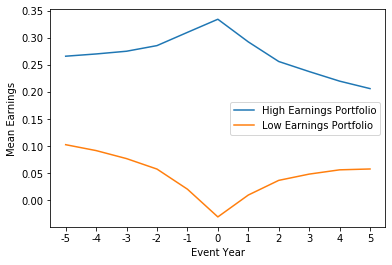

In [0]:
EarningsMean = funda5.groupby(['EarningsDecile'])[['EarningsComp_lag5','EarningsComp_lag4','EarningsComp_lag3',
  'EarningsComp_lag2','EarningsComp_lag1','EarningsComp','EarningsComp_lead1','EarningsComp_lead2','EarningsComp_lead3',
  'EarningsComp_lead4','EarningsComp_lead5']].mean().transpose()
EarningsMean = EarningsMean[['Low','High']]
EarningsMean = EarningsMean.rename(index={'EarningsComp_lag5':'-5','EarningsComp_lag4':'-4','EarningsComp_lag3':'-3',
                                          'EarningsComp_lag2':'-2','EarningsComp_lag1':'-1'})
EarningsMean = EarningsMean.rename(index={'EarningsComp_lead5':'5','EarningsComp_lead4':'4','EarningsComp_lead3':'3',
                                          'EarningsComp_lead2':'2','EarningsComp_lead1':'1','EarningsComp':'0'})
plt.xlabel('Event Year')
plt.ylabel('Mean Earnings')
plt.plot(EarningsMean["High"],label='High Earnings Portfolio')
plt.plot(EarningsMean["Low"],label='Low Earnings Portfolio')
plt.legend()

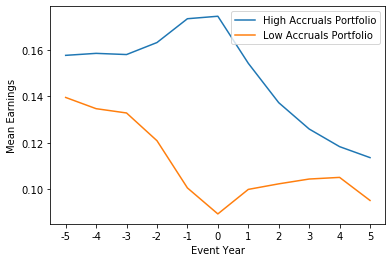

In [0]:
EarningsMean = funda5.groupby(['AccrualsDecile'])[['EarningsComp_lag5','EarningsComp_lag4','EarningsComp_lag3','EarningsComp_lag2',
                                'EarningsComp_lag1','EarningsComp','EarningsComp_lead1','EarningsComp_lead2',
                                'EarningsComp_lead3','EarningsComp_lead4','EarningsComp_lead5']].mean().transpose()
EarningsMean = EarningsMean[['Low','High']]
EarningsMean = EarningsMean.rename(index={'EarningsComp_lag5':'-5','EarningsComp_lag4':'-4','EarningsComp_lag3':'-3',
                                          'EarningsComp_lag2':'-2','EarningsComp_lag1':'-1'})
EarningsMean = EarningsMean.rename(index={'EarningsComp_lead5':'5','EarningsComp_lead4':'4','EarningsComp_lead3':'3',
                                          'EarningsComp_lead2':'2','EarningsComp_lead1':'1','EarningsComp':'0'})
plt.xlabel('Event Year')
plt.ylabel('Mean Earnings')
plt.plot(EarningsMean["High"],label='High Accruals Portfolio')
plt.plot(EarningsMean["Low"],label='Low Accruals Portfolio')
plt.legend()

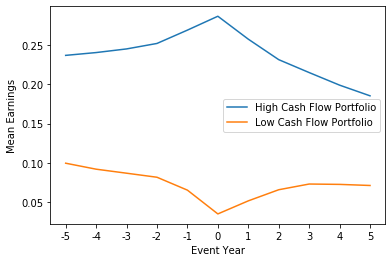

In [0]:
EarningsMean = funda5.groupby(['CFDecile'])[['EarningsComp_lag5','EarningsComp_lag4','EarningsComp_lag3','EarningsComp_lag2',
                  'EarningsComp_lag1','EarningsComp','EarningsComp_lead1','EarningsComp_lead2','EarningsComp_lead3',
                  'EarningsComp_lead4','EarningsComp_lead5']].mean().transpose()
EarningsMean = EarningsMean[['Low','High']]
EarningsMean = EarningsMean.rename(index={'EarningsComp_lag5':'-5','EarningsComp_lag4':'-4','EarningsComp_lag3':'-3',
                                          'EarningsComp_lag2':'-2','EarningsComp_lag1':'-1'})
EarningsMean = EarningsMean.rename(index={'EarningsComp_lead5':'5','EarningsComp_lead4':'4','EarningsComp_lead3':'3',
                                          'EarningsComp_lead2':'2','EarningsComp_lead1':'1','EarningsComp':'0'})
plt.xlabel('Event Year')
plt.ylabel('Mean Earnings')
plt.plot(EarningsMean["High"],label='High Cash Flow Portfolio')
plt.plot(EarningsMean["Low"],label='Low Cash Flow Portfolio')
plt.legend()